In [1]:
import ampal
import isambard
import isambard.specifications as specifications
import isambard.modelling as modelling
import isambard.optimisation as optimisation
import isambard.optimisation.evo_optimizers as ev_opts
from isambard.optimisation.evo_optimizers import Parameter
import budeff

import matplotlib.pyplot as plt
import numpy as np
import itertools
from pprint import pprint
import nglview as nv
from contextlib import redirect_stdout

%matplotlib inline

In [2]:
def show_ball_and_stick(ampal):
    view = nv.show_text(ampal.pdb)
    view.add_ball_and_stick()
    view.remove_cartoon()
    return view

In [3]:
class UpDownUpHomoTrimer(specifications.CoiledCoil):
    """Specification for creating up-down-up, homotrimeric coiled coils."""
    
    oligomeric_state = 3
    
    # The only thing that we need to define is a new `__init__` method, which defines
    # how the class is created. We get all the rest of the functionality off the
    # parent class `CoiledCoil`.
    def __init__(self, helix_length, radius, pitch, phica, zshift):
        # To kick everything off, this class runs the standard setup of the `CoiledCoil`
        # class, which gives our class all of the same attributes and methods. The
        # `super` function gives us access to the parent class. As we want to modify
        # some of the parameters before building the model, we set `auto_build` to false
        super().__init__(self.oligomeric_state, auto_build=False)
        
        # Next, we redefine the relevant default values that `CoiledCoil` has set. As
        # we have 3 helices, we have 3 values for each of these, but in this case they
        # are the same as we're making a homotrimer
        self.aas = [helix_length, helix_length, helix_length]
        self.major_radii = [radius, radius, radius]
        self.major_pitches = [pitch, pitch, pitch]
        self.z_shifts = [0, zshift, 0]
        self.phi_c_alphas = [phica, phica, phica]
        
        # We need to set the orientation of the helices
        self.orientations = [1, -1, 1] # up-down-up specification

        # Now we've redefined these values, we need to build the model from these
        # parameters. We can do this using the build method, which comes from
        # `CoiledCoil`
        self.build()

In [4]:
REGISTER_ADJUST = {
    'a': 0,
    'b': 102.8,
    'c': 205.6,
    'd': 308.4,
    'e': 51.4,
    'f': 154.2,
    'g': 257
}

In [5]:
sequences = ['GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY', 'GEIAALKQEIAALKKENAALKWEIAALKQGYY']

In [6]:
def get_bude_total_energy(ampal_object):
    return budeff.get_internal_energy(ampal_object).total_energy

In [7]:
parameters = [
    optimisation.Parameter.static('Helix Length', 32),
    optimisation.Parameter.dynamic('Radius', 6.0, 1.0),
    optimisation.Parameter.dynamic('Pitch', 200, 60),
    optimisation.Parameter.dynamic('PhiCA', REGISTER_ADJUST['f'], 27),
    optimisation.Parameter.dynamic('ZShift', 10, 10),
]

In [8]:
default_values = [x.default_value for x in parameters]
print(default_values)

[32, 6.0, 200, 154.2, 10]


### Genetic Algorithm

In [9]:
opt_ga = ev_opts.GA(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

In [10]:
opt_ga.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	68   	-1216.55	152.584	-1458.26	-916.273
1  	71   	-1346.84	47.3204	-1476.16	-1258.4 
2  	82   	-1376.93	36.0872	-1476.16	-1325.71
3  	90   	-1415.56	33.0502	-1501.28	-1366.65
4  	64   	-1440.57	27.0525	-1501.28	-1400.18
5  	70   	-1460.31	20.8368	-1504.44	-1422.81
6  	63   	-1474.68	14.774 	-1511.64	-1446.1 
7  	70   	-1482.62	11.5065	-1511.64	-1466.71
8  	68   	-1486.31	10.5913	-1511.64	-1472.35
9  	75   	-1496.31	9.08114	-1515.01	-1479.74
10 	74   	-1502.21	7.4657 	-1515.01	-1486.98
11 	69   	-1508.52	3.59092	-1515.32	-1501.74
12 	64   	-1510.37	2.89834	-1516.89	-1504.35
13 	80   	-1512.3 	1.89115	-1517.12	-1508.39
14 	77   	-1513.44	1.68922	-1517.38	-1510.82
15 	95   	-1514.31	1.58444	-1519.46	-1512.03
16 	76   	-1515.09	1.45424	-1519.46	-1512.99
17 	62   	-1515.47	1.35486	-1519.46	-1513.52
18 	63   	-1515.93	1.4353 	-1519.54	-1514.05
19 	69   	-1516.42	1.35929	-1519.54	-1514.46
20 	79   	-1516.7 	1.20147	-1519.54	-1515.12
21 	74   	

In [11]:
optimized_model_ga = opt_ga.best_model

In [12]:
budeff.get_internal_energy(optimized_model_ga).total_energy

-1520.0008987531376

In [13]:
funnel_data_ga = opt_ga.make_energy_funnel_data()

In [14]:
xs = [x[0] for x in funnel_data_ga]
ys = [x[1] for x in funnel_data_ga]
zs = [x[2] for x in funnel_data_ga]

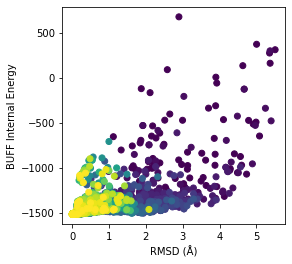

In [15]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('ga.png')

In [16]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-ga.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_ga.pdb)

### Differential Evolution

In [17]:
opt_de = ev_opts.DE(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [18]:
opt_de.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-1147.19	270.548	-1462.74	-18.4187
1  	100  	-1277.7 	163.272	-1462.74	-544.381
2  	100  	-1354.1 	90.1631	-1488.56	-1028.32
3  	100  	-1383.45	67.5155	-1488.56	-1104.92
4  	100  	-1407.09	52.58  	-1505.13	-1116.57
5  	100  	-1425.82	43.8909	-1515.03	-1312.59
6  	100  	-1440.54	41.3244	-1521.28	-1344.24
7  	100  	-1450.69	35.8193	-1521.28	-1355.34
8  	100  	-1465.7 	31.9918	-1532.5 	-1367.54
9  	100  	-1475.04	25.9893	-1532.5 	-1408.42
10 	100  	-1482.01	25.5495	-1537.71	-1421.39
11 	100  	-1485.11	24.1702	-1537.71	-1421.93
12 	100  	-1490.66	23.9498	-1537.71	-1421.93
13 	100  	-1495.75	20.7148	-1537.71	-1435.2 
14 	100  	-1499.15	20.3066	-1542.96	-1435.2 
15 	100  	-1505.97	18.701 	-1542.96	-1453.11
16 	100  	-1510.61	16.4452	-1542.96	-1472.15
17 	100  	-1515.27	15.3756	-1545.54	-1472.15
18 	100  	-1520.23	13.7471	-1546.68	-1487.22
19 	100  	-1523.16	13.0416	-1548.57	-1487.22
20 	100  	-1526.06	11.1644	-1548.57	-1497.19
21 	100  	

In [19]:
optimized_model_de = opt_de.best_model
budeff.get_internal_energy(optimized_model_de).total_energy

-1552.3861021776388

In [20]:
funnel_data_de = opt_de.make_energy_funnel_data()

In [21]:
xs = [x[0] for x in funnel_data_de]
ys = [x[1] for x in funnel_data_de]
zs = [x[2] for x in funnel_data_de]

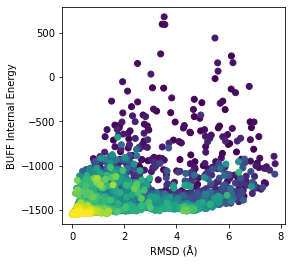

In [22]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('de.png')

In [23]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-de.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_de.pdb)

### Particle Swarm Optimisation

In [24]:
opt_pso = ev_opts.PSO(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [25]:
opt_pso.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min    	max    
0  	100  	-1137.82	324.924	-1465.5	57.1207
1  	80   	-1255.33	250.295	-1473.87	32.5963
2  	68   	-1305.75	157.924	-1475.26	-696.574
3  	77   	-1104.66	278.677	-1504.63	-271.636
4  	87   	-1129.32	278.123	-1469.36	105.064 
5  	81   	-1247.09	199.355	-1475.29	-358.373
6  	49   	-1321.74	141.592	-1484.97	-690.768
7  	68   	-1106.65	325.832	-1476.3 	-189.129
8  	84   	-1114.31	263.669	-1474.89	-145.197
9  	94   	-1263.29	165.497	-1451.89	-533.098
10 	61   	-1284.73	166.527	-1458.98	-529.052
11 	66   	-1253.53	203.868	-1490.7 	-483.474
12 	71   	-1282.78	160.895	-1460.19	-635.412
13 	78   	-1201.61	233.801	-1475.82	-287.684
14 	84   	-1204.63	253.118	-1485.29	-381.29 
15 	84   	-1286.52	182.704	-1475.27	-370.27 
16 	66   	-1297.75	150.813	-1469.06	-817.802
17 	65   	-1284.93	159.894	-1480.07	-768.574
18 	83   	-1248.24	179    	-1474.35	-720.152
19 	91   	-1292.08	191.714	-1482.62	-487.126
20 	76   	-1250.54	257.029	-1502.87	464.724 
21 	77   	-1021

In [26]:
optimized_model_pso = opt_pso.best_model
budeff.get_internal_energy(optimized_model_pso).total_energy

-1505.8259492095187

In [27]:
funnel_data_pso = opt_pso.make_energy_funnel_data()

In [28]:
xs = [x[0] for x in funnel_data_pso]
ys = [x[1] for x in funnel_data_pso]
zs = [x[2] for x in funnel_data_pso]

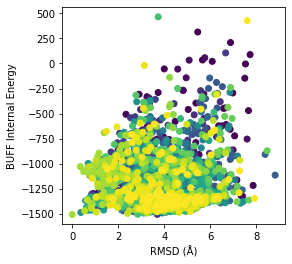

In [29]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('pso.png')

In [30]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-pso.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_pso.pdb)

### Covariance Matrix Adaptive Evolutionary Strategy

In [31]:
opt_cmaes = ev_opts.CMAES(UpDownUpHomoTrimer, sequences, parameters, get_bude_total_energy)

/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/eva/anaconda3/lib/python3.9/site-packages/deap/creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [32]:
opt_cmaes.run_opt(100, 30, cores=8)

gen	evals	avg     	std    	min     	max     
0  	100  	-1009.47	235.625	-1405.98	-39.2525
1  	100  	-1134.86	312.518	-1453.67	239.02  
2  	100  	-1193.97	338.698	-1435.35	350.829 
3  	100  	-1306.7 	154.685	-1474.26	-568.741
4  	100  	-1355.49	88.3153	-1470.99	-1030.51
5  	100  	-1339.12	111.454	-1494.72	-925.56 
6  	100  	-1370.75	123.396	-1508.67	-789.275
7  	100  	-1356.62	180.204	-1505.49	-492.622
8  	100  	-1432.68	98.5603	-1507.18	-793.289
9  	100  	-1456.99	48.5588	-1502.19	-1128   
10 	100  	-1451.12	104.692	-1506.74	-948.065
11 	100  	-1454.53	96.243 	-1511.07	-946.859
12 	100  	-1412.07	172.432	-1515.52	-515.641
13 	100  	-1404.67	167.164	-1518.92	-486.928
14 	100  	-1410.63	187.288	-1508.34	-534.203
15 	100  	-1462.14	101.518	-1516.34	-903.956
16 	100  	-1458.84	118.704	-1517.48	-858.701
17 	100  	-1453.21	112.984	-1519.41	-1005.11
18 	100  	-1449.28	123.982	-1518.12	-943.244
19 	100  	-1478.56	85.0757	-1517.96	-1099.31
20 	100  	-1486.58	71.7774	-1518.67	-1206.72
21 	100  	

In [33]:
optimized_model_cmaes = opt_cmaes.best_model
budeff.get_internal_energy(optimized_model_cmaes).total_energy

-1520.3479538578451

In [34]:
funnel_data_cmaes = opt_cmaes.make_energy_funnel_data()

In [35]:
xs = [x[0] for x in funnel_data_cmaes]
ys = [x[1] for x in funnel_data_cmaes]
zs = [x[2] for x in funnel_data_cmaes]

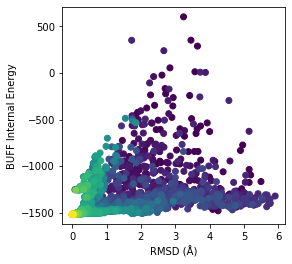

In [36]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(4, 4)
#ax.grid()
ax.scatter(xs, ys, c=zs)
ax.set_xlabel('RMSD (Å)')
ax.set_ylabel('BUFF Internal Energy')

fig.savefig('cmaes.png')

In [37]:
f = open('d_CC-Di_trimer_up_down_up-optimized-model-cmaes.pdb', 'w')

with redirect_stdout(f):
    print(optimized_model_cmaes.pdb)